# Sweeps in 1000 genomes male X haplotypes

In [1]:
import os, sys, math
from pathlib import Path
import numpy
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

numpy.random.seed(7)

Import variables global to the entire analysis:

In [2]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [3]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

from hg19_chrom_sizes import hg19_chrom_sizes

Plotting setup:

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Ignore warnings:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

### Load data

In [31]:
df_list = list()
for chrom in ['X']:
    for tup in ag.g1000_pop_info.itertuples():
        df = pd.read_hdf(ag.steps_dir / '1000genomes' / \
                'male_dist_admix_masked_stores' / chrom / tup.population / 'sweep_data_5e-05_30%.hdf')
        df['chrom'] = chrom
        df['population'] = tup.population
        df['superpop'] = tup.superpop
        df_list.append(df)
    
sweep_data = pd.concat(df_list)

sweep_data['superpop'] = pd.Categorical(sweep_data.superpop, 
                                        categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'], 
                                        ordered=True)
sweep_data.head()

,indiv_1,start,end,mean_dist,mean_dist_af,prop_indivs_missing,win_swept,win_swept_af,called,called_af,...,clade_size_af,run_id,run_length,swept,run_id_af,run_length_af,swept_af,chrom,population,superpop
0,HG02461,0,100000,NaN,NaN,1.0,False,False,False,False,...,NaN,1,22,False,1,22,False,X,GWD,AFR
1,HG02461,100000,200000,NaN,NaN,1.0,False,False,False,False,...,NaN,1,22,False,1,22,False,X,GWD,AFR
2,HG02461,200000,300000,NaN,NaN,1.0,False,False,False,False,...,NaN,1,22,False,1,22,False,X,GWD,AFR
3,HG02461,300000,400000,NaN,NaN,1.0,False,False,False,False,...,NaN,1,22,False,1,22,False,X,GWD,AFR
4,HG02461,400000,500000,NaN,NaN,1.0,False,False,False,False,...,NaN,1,22,False,1,22,False,X,GWD,AFR


In [88]:
ag.g1000_pop_info.style.set_properties(**{'text-align': 'left'})

,population,description,superpop
12,GWD,Gambian in Western Divisions in the Gambia,AFR
16,ACB,African Caribbeans in Barbados,AFR
10,YRI,"Yoruba in Ibadan, Nigeria",AFR
11,LWK,"Luhya in Webuye, Kenya",AFR
15,ASW,Americans of African Ancestry in SW USA,AFR
13,MSL,Mende in Sierra Leone,AFR
14,ESN,Esan in Nigeria,AFR
5,CEU,Utah Residents (CEPH) with Northern and Western European Ancestry,EUR
6,TSI,Toscani in Italia,EUR
7,FIN,Finnish in Finland,EUR


## Missing regions

## Stats on sweeps

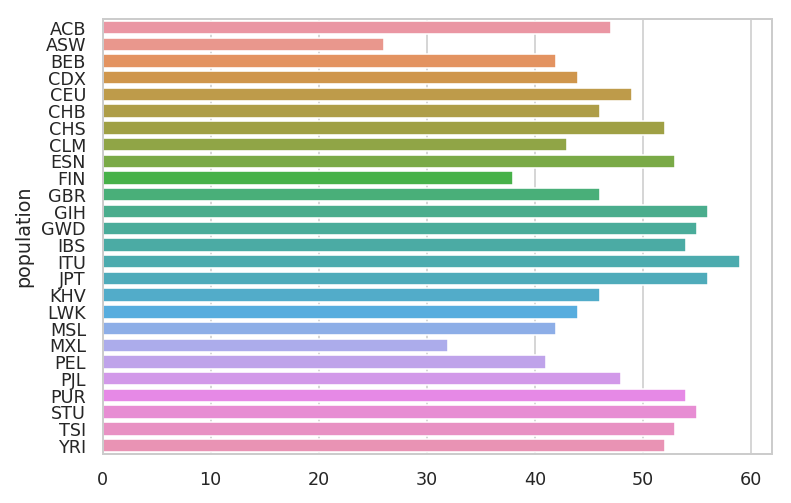

In [18]:
sr = sweep_data.groupby('population').apply(lambda df: df.indiv_1.unique().size)
sns.barplot(sr, sr.index)


## Proportion swept

In [34]:
# group by start, end, region and compute size
plot_df = (sweep_data
           .groupby(['start', 'end', 'superpop', 'population'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(prop_swept=lambda df: df.nr_swept / df.total)
          )
plot_df.head()

,start,end,superpop,population,nr_swept,total,prop_swept
0,0,100000,AFR,ACB,0.0,47,0.0
1,0,100000,AFR,ASW,0.0,26,0.0
2,0,100000,AFR,ESN,0.0,53,0.0
3,0,100000,AFR,GWD,0.0,55,0.0
4,0,100000,AFR,LWK,0.0,44,0.0


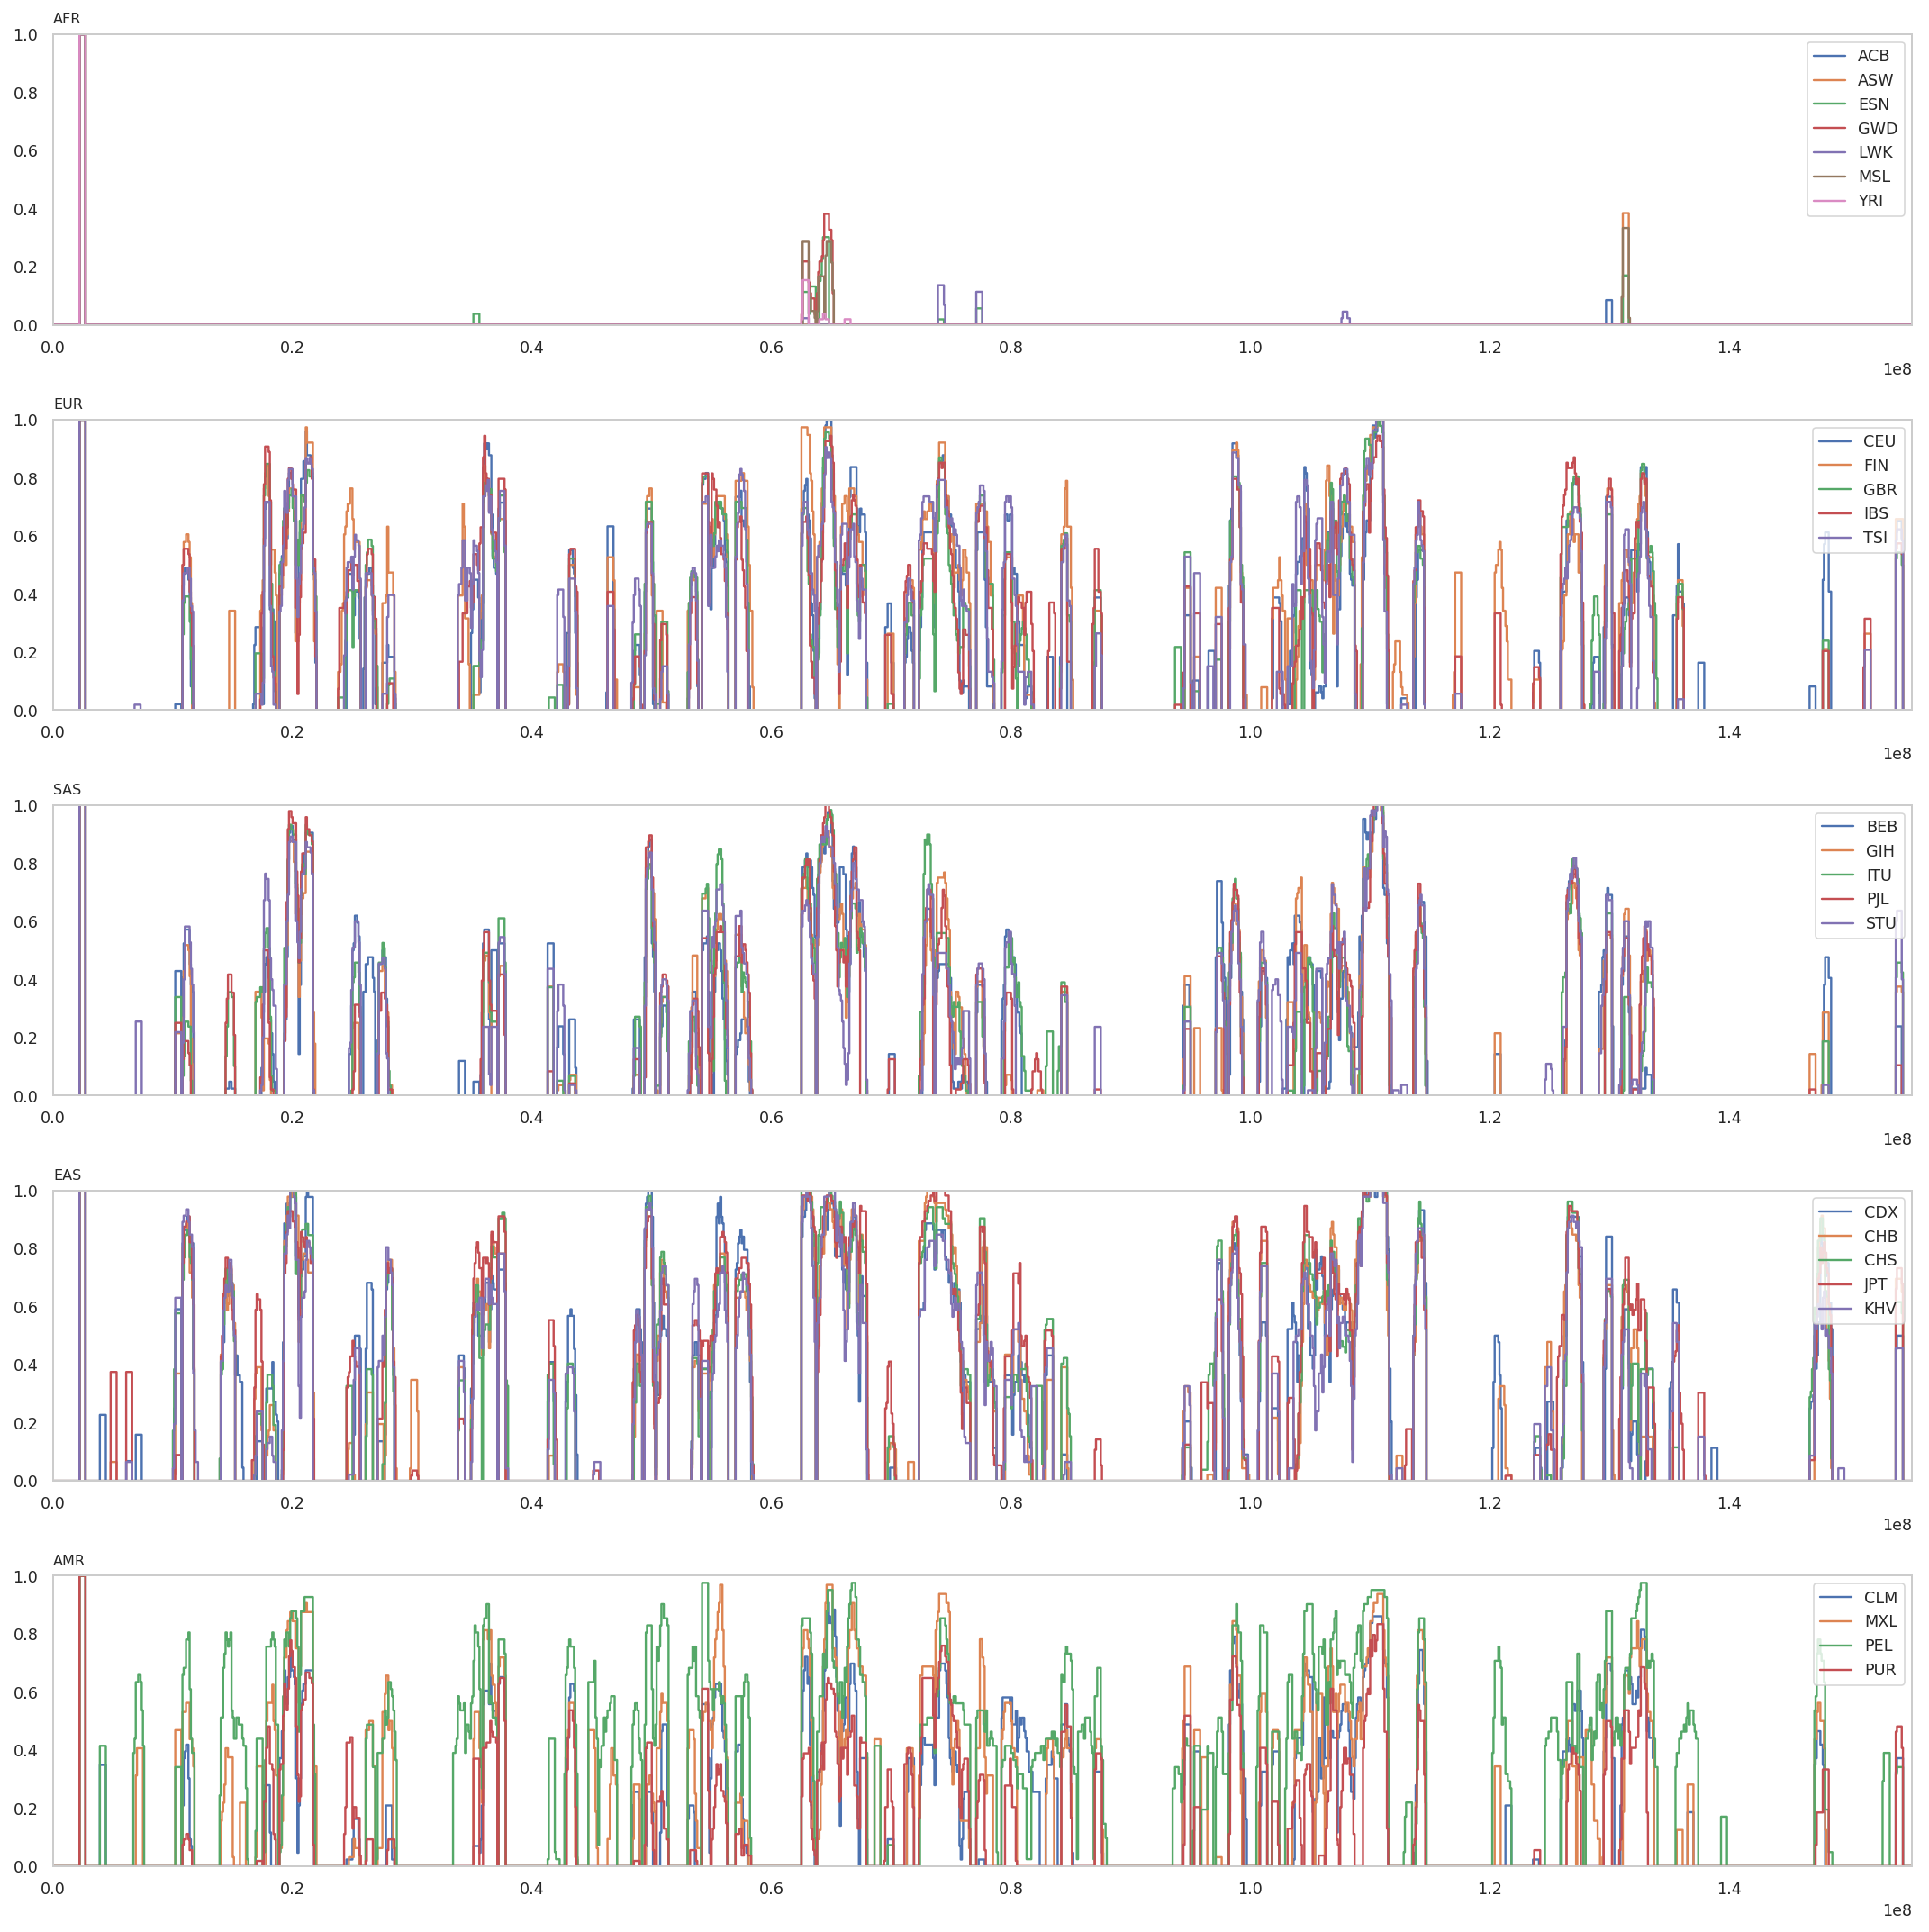

In [90]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(5, 1, sharey=True, figsize=(15, 15),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})

    for ax, (superpop, super_df) in zip(axes, plot_df.groupby('superpop')):
        ax.set_title(superpop, loc='left', fontsize=8)

        for (population, pop_df) in super_df.groupby('population'):
            df = stairs(pop_df)
            ax.plot(df.pos, df.prop_swept, label=population)
        ax.legend(loc='upper right')

    plt.tight_layout()
plt.savefig(str(ag.figures_dir / "g1000_ech.pdf"))

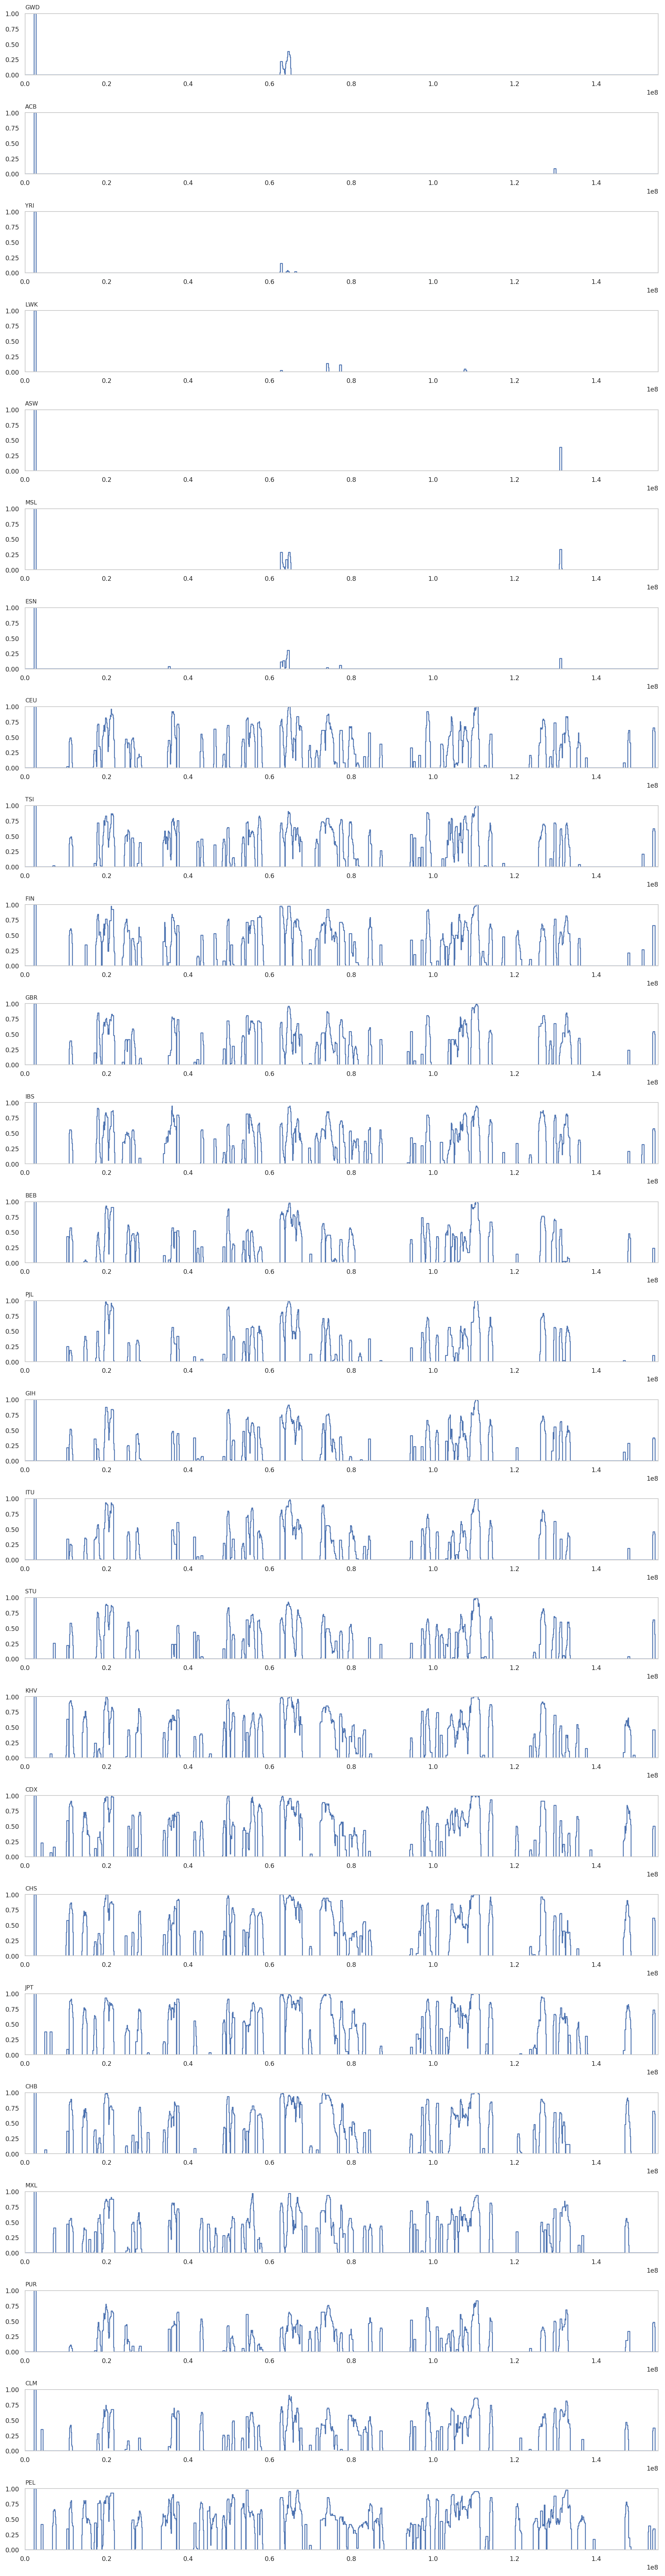

In [33]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(26, 1, sharey=True, figsize=(13, 50),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
    for ax, population in zip(axes, ag.g1000_pop_info.population):
        df = stairs(plot_df.loc[plot_df.population == population])
        ax.plot(df.pos, df.prop_swept)
        ax.set_title(population, loc='left', fontsize=8)
    plt.tight_layout()

    

In [ ]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(26, 1, sharex=True, sharey=True, figsize=(10, 10),                         
                             subplot_kw={'xlim':(0, chromosome_lengths['X']),
                                         'ylim':(0, 1)})

    for ax, population in zip(axes, g1000_populations):
        df = plot_df.loc[plot_df.population == population]    
        
        for tup in df.itertuples():
            if tup.nr_swept:
                g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, tup.nr_swept/tup.total, 
#                                  facecolor=region_colors[reg], 
                                 linewidth=0,
                                 #edgecolor=None,#region_colors[reg], 
                                 zorder=2))
        ax.set_title(reg, loc='left')
                
        for tup in missing_regions.loc[missing_regions.is_missing == True].itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                     facecolor='lightgray', 
                     linewidth=0,
#                     edgecolor=None,
                     alpha=0.5,
                     zorder=1))
    #     ax.set_ylim(0, df.nr_swept.max())

    plt.tight_layout()
    
    plt.savefig(str(figures_dir / "tot_swept_by_region.pdf"))
    #plt.close() # closing teh plot suppres automatic plotting without plt.show()